This notebook will explore various temperature values for the CEBRA model to produce reasaonable embeddings for simple inputs.

In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


NameError: name 'cebra_output' is not defined

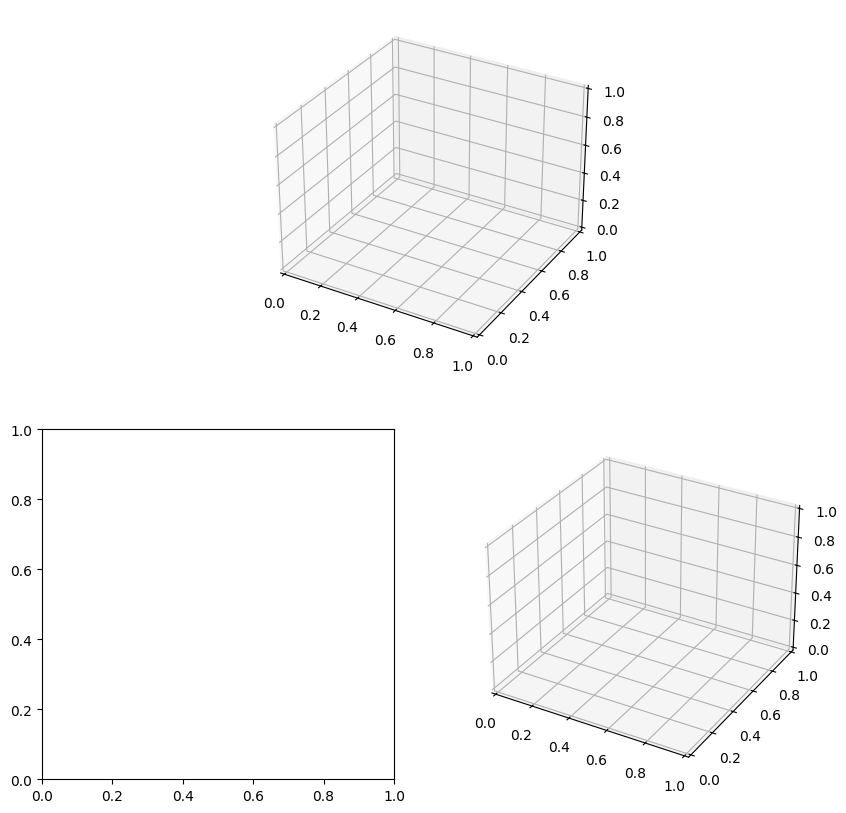

In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import d_library as dl
import sklearn.linear_model

from matplotlib.collections import LineCollection
import pandas as pd

## Define Data

The lorenz attractor and a simple 2D circle will be used as inputs to the CEBRA model to test the performance CEBRA.

Let's start with the 2D circle

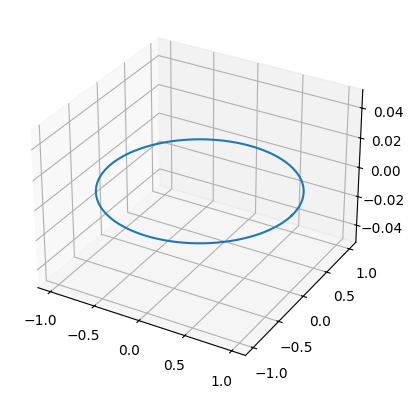

(100, 3)

In [ ]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

Now let's get our second input: the Lorenz attractor

In [ ]:
xyz = dl.make_lorenz()

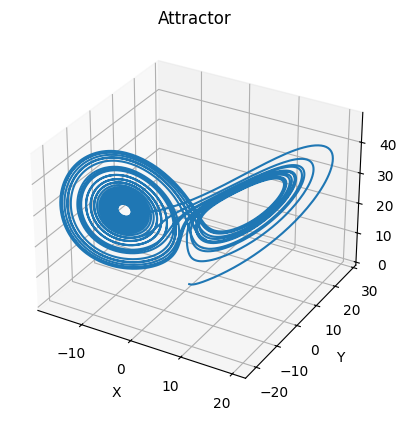

In [ ]:
dl.plot_lorenz(xyz)

In [ ]:
# reshape it for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

## Fixed Temperature Model:

In [ ]:
iterations = 2000

In [ ]:
np.random.rand(1000)[:10]

array([0.83886229, 0.36183311, 0.78508971, 0.34834088, 0.82679229,
       0.15703338, 0.39859428, 0.73184122, 0.2761291 , 0.89046907])

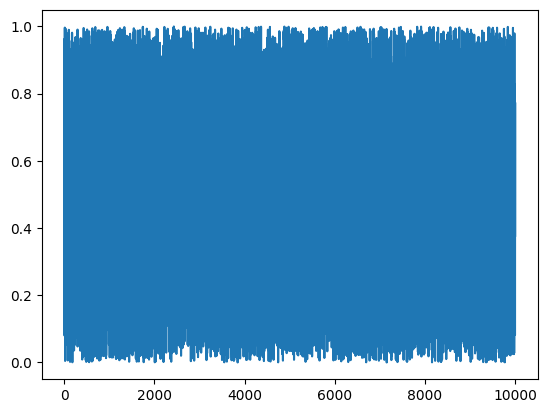

In [ ]:
plt.plot(np.random.rand(10000))

In [ ]:
# function to get an embedding    
def base_embed(input, temp=1, dimension=3, lr = 0.01):
# build CEBRA time model
    
    # make label here?
    b_label = np.random.rand(input.shape[0])

    fixed_temp_model = CEBRA(model_architecture='offset1-model-mse',
                            batch_size=512,
                            learning_rate=int(lr),
                            temperature=int(temp),
                            output_dimension = int(dimension),
                            max_iterations=iterations,
                            delta=0.5,
                            distance='euclidean',
                            conditional='time_delta',
                            device='cuda_if_available',
                            num_hidden_units=64,
                            verbose=True,
                            time_offsets=1)

    train_size = int((input.shape[0])*0.75)    
    fixed_temp_model.fit(input[:train_size], b_label[:train_size])
    embedding = fixed_temp_model.transform(input)
    return fixed_temp_model, embedding

In [ ]:
# get the embeddings
ft_model_c, ft_embedding_c = base_embed(circle, lr=0.1)
ft_model_l, ft_embedding_l = base_embed(lorenz_obj, lr=0.01)

pos:  0.0019 neg:  6.2363 total:  6.2382 temperature:  1.0000: 100%|██████████| 2000/2000 [00:23<00:00, 85.07it/s]
pos:  0.1903 neg:  6.0231 total:  6.2135 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 81.71it/s]


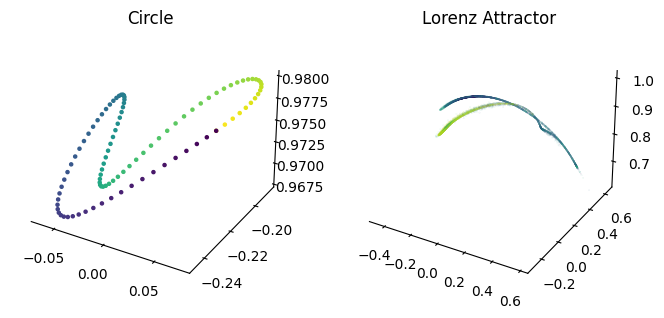

In [ ]:
# plot the embeddings
dl.plot_2embeddings(ft_embedding_c,ft_embedding_l)

## Learnable temperature model

Setting temperature_mode to auto will make the temperature to be optimized during the training of a model.

min_temperature is the lower bound for the tempearture. If not specified, min_temperature is set to asymptotic 0. (from CEBRA documentation)

In [ ]:
# function to get an embedding    
def base_embed_l(input, temp=1, dimension=3, lr = 0.01):
# build CEBRA time model
    fixed_temp_model = CEBRA(model_architecture='offset1-model',
                            batch_size=512,
                            learning_rate=int(lr),
                            temperature_mode='auto',
                            min_temperature=0.1,
                            delta=0.5,
                            output_dimension = int(dimension),
                            max_iterations=iterations,
                            distance='euclidean',
                            conditional='delta',
                            device='cuda_if_available',
                            num_hidden_units=64,
                            verbose=True,
                            time_offsets=1)

    fixed_temp_model.fit(input)
    embedding = fixed_temp_model.transform(input)
    return fixed_temp_model, embedding

In [ ]:
# get the embeddings
lt_model_c, lt_embedding_c = base_embed_l(circle, lr=0.1)
lt_model_l, lt_embedding_l = base_embed_l(lorenz_obj, lr=0.01)

pos:  0.0000 neg:  6.2234 total:  6.2234 temperature:  1.0000: 100%|██████████| 2000/2000 [00:26<00:00, 74.18it/s]
pos:  0.0005 neg:  6.0410 total:  6.0414 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 82.31it/s]


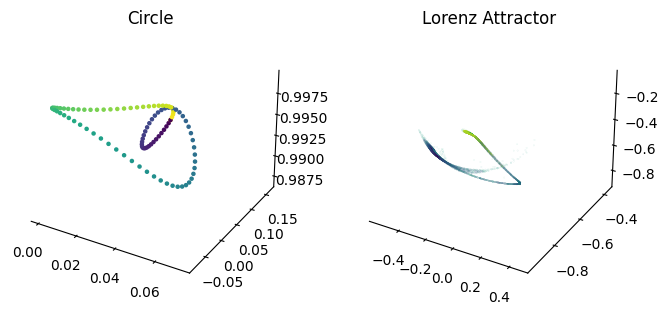

In [ ]:
# plot the embeddings
dl.plot_2embeddings(lt_embedding_c,lt_embedding_l)

In [ ]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

## Visualize the Loss and the temperature

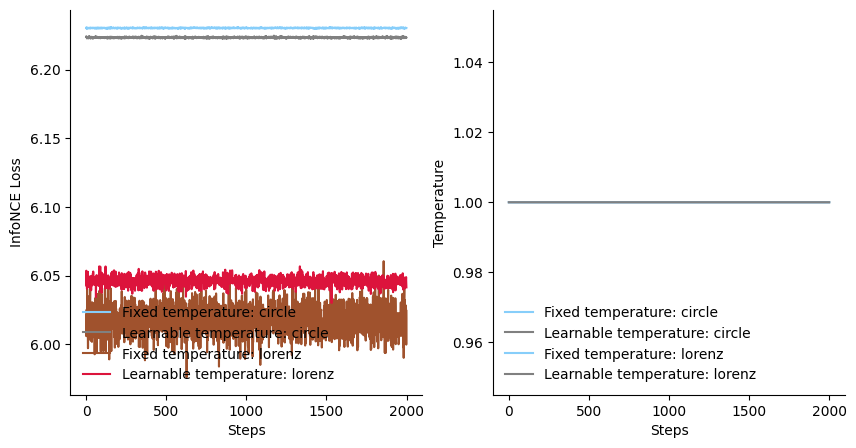

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)

ax1.plot(ft_model_c.state_dict_['loss'], c='lightskyblue', label='Fixed temperature: circle')
ax1.plot(lt_model_c.state_dict_['loss'], c='gray', label = 'Learnable temperature: circle')

ax1.plot(ft_model_l.state_dict_['loss'], c='sienna', label='Fixed temperature: lorenz')
ax1.plot(lt_model_l.state_dict_['loss'], c='crimson', label = 'Learnable temperature: lorenz')

ax1.set_ylabel('InfoNCE Loss')
ax1.set_xlabel('Steps')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.legend(loc = 'lower left', frameon = False)


ax2= plt.subplot(122)
ax2.plot(ft_model_c.state_dict_['log']['temperature'], c='lightskyblue', label='Fixed temperature: circle')
ax2.plot(lt_model_c.state_dict_['log']['temperature'], c='gray', label = 'Learnable temperature: circle')

ax2.plot(ft_model_l.state_dict_['log']['temperature'], c= 'lightskyblue', label='Fixed temperature: lorenz')
ax2.plot(lt_model_l.state_dict_['log']['temperature'], c='gray', label = 'Learnable temperature: lorenz')


ax2.set_ylabel('Temperature')
ax2.set_xlabel('Steps')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.legend(loc = 'lower left', frameon = False)

Rerun this notebook and change some of the parameters so that the loss converges: start with the model architecture.